# MCMC Assessment Notebook -- Cohort 1, March 2021

In [ ]:
%matplotlib notebook

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, stats

## MCMC Assessment Problem:  MALA

Given a distribution with density $p(\theta)$ that is differentiable with respect to $\theta$, consider a continuous-state-space Markov process of the form

$$ \theta_{n+1} = \theta_n + \frac{\epsilon^2}{2} \left. \nabla_\theta \log p(\theta) \right|_{\theta=\theta_n} + \epsilon u, \hspace{0.5in} u \sim N(0,1). $$

(a) Implement this process in the case where $p(\theta)$ is a unit Gaussian.  Yes, there are more interesting distributions but this one is easy to work with, and we'll have only one dimension so the gradient just becomes $\partial/\partial \theta$.  Plot traces from your process for a few different values of $\epsilon$ in the range 0.1 to 10.  Does this process have a unique stationary distribution, and if so, how different is that stationary distribution from $p(\theta)$?

(b) What is missing from this process that is needed to turn it into a MCMC scheme?  Add this to your implementation, and try sampling again from a unit Gaussian.  Comment on the resulting proposal's autocorrelation time relative to a regular Metropolis random walk with the same stepsize.

## General-purpose functions you are free to use throughout the notebook

In [ ]:
# Some generally useful utility functions

def profile_timer(f, *args, **kwargs):
    """
    Times a function call f() and prints how long it took in seconds
    (to the nearest millisecond).
    :param func:  the function f to call
    :return:  same return values as f
    """
    t0 = time.time()
    result = f(*args, **kwargs)
    t1 = time.time()
    print ("time to run {}: {:.3f} sec".format(f.__name__, t1-t0))
    return result

def movieify(plfunc, x, frame_idx, *args, **kwargs):
    """
    Saves figures to a directory to be compiled as an animated GIF.
    :param plfunc:  plotting function to call, which it is assumed
        will initialize a new plt.figure() instance
    :param x:  the input data to plfunc, as an np.array of shape
        (Nsamples, ...); the function will take successive subsets
        of the data to show the progress of sampling
    """
    for Nf in frame_idx:
        savefigfn = "{}_frame_{:06d}.png".format(plfunc.__name__, Nf)
        plfunc(x[:Nf], *args, savefigfn=savefigfn, **kwargs)

### Discrete autocorrelation function of a time series

In [ ]:
def autocorr(x, D, plot=True):
    """
    Discrete autocorrelation function + integrated autocorrelation time.
    Calculates directly, though could be sped up using Fourier transforms.
    See Daniel Foreman-Mackey's tutorial (based on notes from Alan Sokal):
    https://emcee.readthedocs.io/en/stable/tutorials/autocorr/

    :param x: np.array of data, of shape (Nsamples, Ndim)
    :param D: number of return arrays
    """
    # Baseline discrete autocorrelation:  whiten the data and calculate
    # the mean sample correlation in each window
    xp = np.atleast_2d(x)
    z = (xp-np.mean(xp, axis=0))/np.std(xp, axis=0)
    Ct = np.ones((D, z.shape[1]))
    Ct[1:,:] = np.array([np.mean(z[i:]*z[:-i], axis=0) for i in range(1,D)])
    # Integrated autocorrelation tau_hat as a function of cutoff window M
    tau_hat = 1 + 2*np.cumsum(Ct, axis=0)
    # Sokal's advice is to take the autocorrelation time calculated using
    # the smallest integration limit M that's less than 5*tau_hat[M]
    Mrange = np.arange(len(tau_hat))
    tau = np.argmin(Mrange[:,None] - 5*tau_hat, axis=0)
    print("tau =", tau)
    # Plot if requested
    if plot:
        fig = plt.figure(figsize=(6,4))
        plt.plot(Ct)
        plt.title('Discrete Autocorrelation ($\\tau = {:.1f}$)'.format(np.mean(tau)))
    return np.array(Ct), tau

### Trace plots (shows traces of all parameters with shared, resizeable axis limits)

In [ ]:
def traceplots(x, xnames=None, title=None):
    """
    Runs trace plots.
    :param x:  np.array of shape (N, d)
    :param xnames:  optional iterable of length d, containing the names
        of variables making up the dimensions of x (used as y-axis labels)
    :param title:  optional plot title
    """
    # set out limits of plot spaces, in dimensionless viewport coordinates
    # that run from 0 (bottom, left) to 1 (top, right) along both axes
    N, d = x.shape
    fig = plt.figure()
    left, tracewidth, histwidth = 0.1, 0.65, 0.15
    bottom, rowheight = 0.1, 0.8/d
    spacing = 0.05
    
    for i in range(d):
        # Set the location of the trace and histogram viewports,
        # starting with the first dimension from the bottom of the canvas
        rowbottom = bottom + i*rowheight
        rect_trace = (left, rowbottom, tracewidth, rowheight)
        rect_hist = (left + tracewidth, rowbottom, histwidth, rowheight)
        # First set of trace plot axes
        if i == 0:
            ax_trace = fig.add_axes(rect_trace)
            ax_trace.plot(x[:,i])
            ax_trace.set_xlabel("Sample Count")
            ax_tr0 = ax_trace
        # Other sets of trace plot axes that share the first trace's x-axis
        # Make tick labels invisible so they don't clutter up the plot
        elif i > 0:
            ax_trace = fig.add_axes(rect_trace, sharex=ax_tr0)
            ax_trace.plot(x[:,i])
            plt.setp(ax_trace.get_xticklabels(), visible=False)
        # Title at the top
        if i == d-1 and title is not None:
            plt.title(title)
        # Trace y-axis labels
        if xnames is not None:
            ax_trace.set_ylabel(xnames[i])
        # Trace histograms at the right
        ax_hist = fig.add_axes(rect_hist, sharey=ax_trace)
        ax_hist.hist(x[:,i], orientation='horizontal', bins=50)
        plt.setp(ax_hist.get_xticklabels(), visible=False)
        plt.setp(ax_hist.get_yticklabels(), visible=False)
        xlim = ax_hist.get_xlim()
        ax_hist.set_xlim([xlim[0], 1.1*xlim[1]])

## Part (a)

Since we are working in 1-D, and $p(\theta)$ is a unit gaussian, the Markov process can be re-written as:

$$ \theta_{n+1} = \left(1 - \frac{\epsilon^2}{2}\right)\theta_n + \epsilon u,     \hspace{0.5in} u \sim \mathcal{N}(0,1) $$

Considering the arithmetic properties of the normal distribution, it is also true that:


$$ \theta_{n+1} \sim \mathcal{N}\left((1 - \frac{\epsilon^2}{2})\theta_n, \epsilon^2\right)$$

So now we can implement the Markov chain:

In [198]:
class MarkovProcess:
    
    def __init__(self, N, burn_in):
        self.N = N
        self.burn_in = burn_in
    
    def mp_step(self, theta_n, epsilon):
        mean = (1-(epsilon**2)/2)*theta_n
        std = epsilon
        return np.random.normal(mean, std) 

    def mp(self, theta_0, epsilon):
        chain = [theta_0]
        for _ in range(self.N):
            theta_n_plus_one = mp_step(chain[-1], epsilon)
            chain.append(theta_n_plus_one)
        retained_chain = chain[self.burn_in+1:]
        return retained_chain


    def traceplots(self, epsilon, xnames=None, title=None):
        x = np.array(self.mp(0,epsilon)).reshape(self.N-self.burn_in,1)
        N, d = x.shape
        fig = plt.figure()
        left, tracewidth, histwidth = 0.1, 0.65, 0.15
        bottom, rowheight = 0.1, 0.8/d
        spacing = 0.05

        for i in range(d):
            rowbottom = bottom + i*rowheight
            rect_trace = (left, rowbottom, tracewidth, rowheight)
            rect_hist = (left + tracewidth, rowbottom, histwidth, rowheight)
            if i == 0:
                ax_trace = fig.add_axes(rect_trace)
                ax_trace.plot(x[:,i])
                ax_trace.set_xlabel("Sample Count")
                ax_tr0 = ax_trace
            elif i > 0:
                ax_trace = fig.add_axes(rect_trace, sharex=ax_tr0)
                ax_trace.plot(x[:,i])
                plt.setp(ax_trace.get_xticklabels(), visible=False)
            if i == d-1 and title is not None:
                plt.title(title)
            if xnames is not None:
                ax_trace.set_ylabel(xnames[i])
            ax_hist = fig.add_axes(rect_hist, sharey=ax_trace)
            ax_hist.hist(x[:,i], orientation='horizontal', bins=50)
            plt.setp(ax_hist.get_xticklabels(), visible=False)
            plt.setp(ax_hist.get_yticklabels(), visible=False)
            xlim = ax_hist.get_xlim()
            ax_hist.set_xlim([xlim[0], 1.1*xlim[1]])
            
markovchain = MarkovProcess(1000000,100000)

We now show traceplots of the Markov process for $\epsilon \in$ {0.1, 1.2, 1.8, 1.9, 1.999, 2.0, 2.1}. The original intention was to run ten iterations, from 0.1 to 10 with a step of 1.1. But in the following traceplots, we can see how for low values of $\epsilon$, the chain distributes like a unit gaussian, and as it gets bigger, the variance starts growing until the process no longer converges to a unique stationary distribution, and we are unable to plot it.

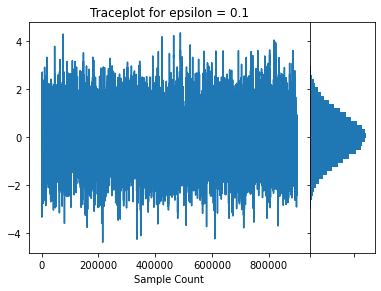

In [199]:
epsilon = 0.1
markovchain.traceplots(epsilon, title="Traceplot for epsilon = %.1f" %epsilon)

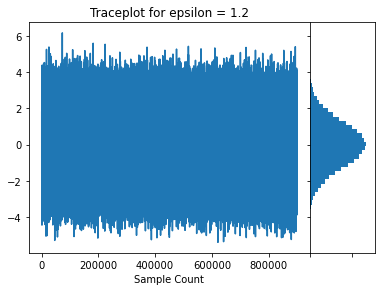

In [200]:
epsilon = 1.2
markovchain.traceplots(epsilon, title="Traceplot for epsilon = %.1f" %epsilon)

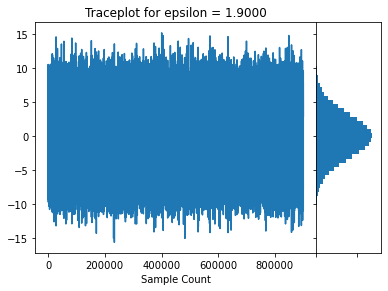

In [201]:
epsilon = 1.9
markovchain.traceplots(epsilon, title="Traceplot for epsilon = %.4f" %epsilon)


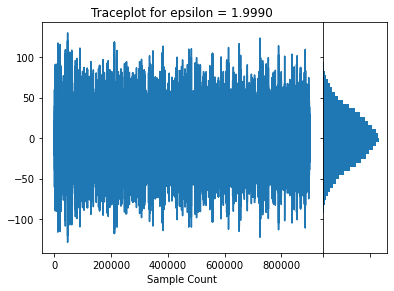

In [170]:
epsilon = 1.999
markovchain.traceplots(epsilon, title="Traceplot for epsilon = %.4f" %epsilon)

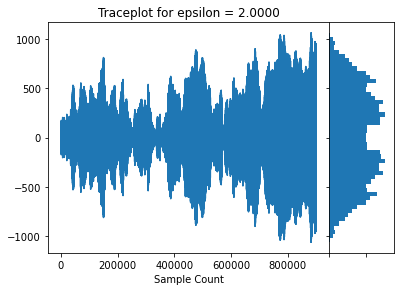

In [202]:
epsilon = 2
markovchain.traceplots(epsilon, title="Traceplot for epsilon = %.4f" %epsilon)

In [ ]:
epsilon = 2.1
markovchain.traceplots(epsilon, title="Traceplot for epsilon = %.4f" %epsilon)

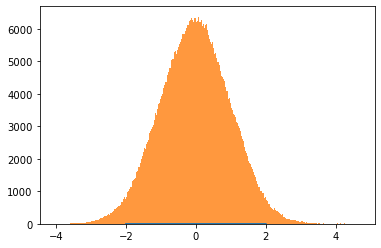

In [403]:
sample = np.array(markovchain.mp(0,0.1))[:,np.newaxis]

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.hist(sample,500,alpha=0.8)
plt.show()





To observe this numerically, we can calculate the mean and variance of each chain, for the previous values of $\epsilon$, to see exactly how similar these chains distributions are to a $\mathcal{N}(0,1) $. The `meanvariance`function was created to aid us on this.

In [190]:
def meanvariance(chain):
    mean = np.mean(np.array(chain))
    variance = np.var(np.array(chain))
    return round(mean,2), round(variance,2)

In [195]:
values = [0.1, 1.2, 1.8, 1.9, 1.999, 2.0, 2.1]
for epsilon in values:
    print("For epsilon =", epsilon, "the chain has mean and variance", meanvariance(markovchain.mp(0,epsilon)))

For epsilon = 0.1 the chain has mean and variance (0.02, 1.01)
For epsilon = 1.2 the chain has mean and variance (-0.0, 1.56)
For epsilon = 1.8 the chain has mean and variance (-0.0, 5.27)
For epsilon = 1.9 the chain has mean and variance (0.0, 10.28)
For epsilon = 1.999 the chain has mean and variance (-0.0, 972.1)
For epsilon = 2.0 the chain has mean and variance (-0.0, 1353298.52)
For epsilon = 2.1 the chain has mean and variance (nan, nan)


The plots and `meanvariance` show that this Markov process is always centered close to 0, and in the case of $\epsilon = 0.1$, it is almost identical to $p(\theta)$, with a variance only 1% higher, and a mean very close to 0. Up until $\epsilon = 1.999$, even though the variance grows, the distributions are still comparable to a normal distribution. But for $\epsilon > 1.999$, the chain doesn't have a unique stationary distribution, and it has nothing in common with any normal distribution, even less so with $p(\theta)$.

## Part (b)

The process from part (a) accepts every new sample that is generated. We suspect that the constant big steps are what's preventing this process from reaching a unique stationary distribution. Putting it into a MCMC scheme will make it less likely to take big steps, since we will have an acceptance criteria that, the bigger the step, the less likely it is to be taken.

We will implement the M-H algorithm. In this case, we're sampling $\theta_{n+1}$ from $\mathcal{N}\left((1 - \frac{\epsilon^2}{2})\theta_n, \epsilon^2\right)$.

The M-H acceptance ratio for this implementation is: 

$$\frac{p(\theta_{n+1})q(\theta_n\mid\theta_{n+1})}{p(\theta_n)q(\theta_{n+1}\mid\theta_n)}$$

Where $$q(\theta_{n+1}\mid\theta_n) = \frac{1}{\sqrt{2\pi\epsilon}}exp\left(\frac{-\left(\theta_{n+1} - \left( 1- \frac{\epsilon^2}{2}\right)\theta_n\right)^2}{2\epsilon^2}\right)$$

Note that we are considering q for this acceptance ratio because this proposal is asymmetric ($q(\theta\rightarrow \theta') \neq (q(\theta' \rightarrow \theta)$).

In [359]:
class Metropolis:
    
    def __init__(self, N, burn_in, method):
        self.method = method
        self.N = N
        self.burn_in = burn_in
    
    def mh_step(self, theta_n, epsilon):
        mean = (1-(epsilon**2)/2)*theta_n
        std = epsilon
        return np.random.normal(mean, std) 
    
    #N(0,1) density
    def p(self, theta_n):
        return 1/np.sqrt(2*np.pi) * np.exp(-0.5*(theta_n)**2)
    
    def q(self,theta_input, theta_n, epsilon):
        return 1/np.sqrt(2*np.pi*epsilon)*np.exp(-1*(theta_input - (1-(epsilon**2)/2)*theta_n)**2/(2*epsilon**2))
    
    #MALA
    def mh(self, theta_0, epsilon):
        chain = [theta_0]
        for _ in range(self.N):

            theta_n_plus_one = self.mh_step(chain[-1], epsilon)
            theta_n = chain[-1]
            
            p_prop = self.p(theta_n_plus_one)
            p_curr = self.p(theta_n)
            
            q_prop = self.q(theta_n_plus_one, theta_n, epsilon)
            q_curr = self.q(theta_n, theta_n_plus_one, epsilon)
            
            alpha = min(1, p_prop*q_curr/(p_curr*q_prop))
            
            if alpha >= np.random.random():
                chain.append(theta_n_plus_one)
                
            else:
                chain.append(theta_n)
                
        retained_chain = chain[self.burn_in+1:]
        return retained_chain
    
    #regular Metropolis random walk
    def mrw(self,epsilon):
        samples = [0]
        for _ in range(self.N):
            sample = samples[-1]

            #Candidate, same stepsize
            candidate = np.random.normal(sample, epsilon)

            #Probability of accepting candidate theta' 
            prob = min(1, self.p(candidate)/self.p(sample))

            #Test acceptance
            if np.random.random() < prob:
                samples.append(candidate)
            else: 
                samples.append(sample)
 
        retained_samples = samples[self.burn_in+1:]
        return retained_samples
    
    def traceplots(self, epsilon, xnames=None, title=None):
        if self.method == "mh":
            x = np.array(self.mh(0,epsilon)).reshape(self.N-self.burn_in,1)
        else:
            x = np.array(self.mrw(0)).reshape(self.N-self.burn_in,1)    
        N, d = x.shape
        fig = plt.figure()
        left, tracewidth, histwidth = 0.1, 0.65, 0.15
        bottom, rowheight = 0.1, 0.8/d
        spacing = 0.05

        for i in range(d):
            rowbottom = bottom + i*rowheight
            rect_trace = (left, rowbottom, tracewidth, rowheight)
            rect_hist = (left + tracewidth, rowbottom, histwidth, rowheight)
            if i == 0:
                ax_trace = fig.add_axes(rect_trace)
                ax_trace.plot(x[:,i])
                ax_trace.set_xlabel("Sample Count")
                ax_tr0 = ax_trace
            elif i > 0:
                ax_trace = fig.add_axes(rect_trace, sharex=ax_tr0)
                ax_trace.plot(x[:,i])
                plt.setp(ax_trace.get_xticklabels(), visible=False)
            if i == d-1 and title is not None:
                plt.title(title)
            if xnames is not None:
                ax_trace.set_ylabel(xnames[i])
            ax_hist = fig.add_axes(rect_hist, sharey=ax_trace)
            ax_hist.hist(x[:,i], orientation='horizontal', bins=50)
            plt.setp(ax_hist.get_xticklabels(), visible=False)
            plt.setp(ax_hist.get_yticklabels(), visible=False)
            xlim = ax_hist.get_xlim()
            ax_hist.set_xlim([xlim[0], 1.1*xlim[1]])
            
    def autocorr(self, epsilon, D, plot=False):
        """
        Discrete autocorrelation function + integrated autocorrelation time.
        Calculates directly, though could be sped up using Fourier transforms.
        See Daniel Foreman-Mackey's tutorial (based on notes from Alan Sokal):
        https://emcee.readthedocs.io/en/stable/tutorials/autocorr/

        :param x: np.array of data, of shape (Nsamples, Ndim)
        :param D: maximum autocorrelation lag (integer, less than Nsamples)
        """
        # Baseline discrete autocorrelation:  whiten the data and calculate
        # the mean sample correlation in each window
        if D > self.N:
            print('D must be less than N')
            return 0
        else:
            if self.method == "mh":
                x = self.mh(0,epsilon)
            else:
                x = self.mrw(epsilon)
            xp = np.atleast_2d(np.array(x).reshape(self.N-self.burn_in,1))
            z = (xp-np.mean(xp, axis=0))/np.std(xp, axis=0)
            Ct = np.ones((D, z.shape[1]))
            Ct[1:,:] = np.array([np.mean(z[i:]*z[:-i], axis=0) for i in range(1,D)])
            # Integrated autocorrelation tau_hat as a function of cutoff window M
            tau_hat = 1 + 2*np.cumsum(Ct, axis=0)
            # Sokal's advice is to take the autocorrelation time calculated using
            # the smallest integration limit M that's less than 5*tau_hat[M]
            Mrange = np.arange(len(tau_hat))
            tau = np.argmin(Mrange[:,None] - 5*tau_hat, axis=0)
            # Plot if requested
            if plot:
                fig = plt.figure(figsize=(6,4))
                plt.plot(Ct)
                plt.title('Discrete Autocorrelation ($\\tau = {:.1f}$)'.format(np.mean(tau)))
                plt.show()
            return tau

            
                
                
mh = Metropolis(100000, 10000, "mh")
mrw = Metropolis(100000, 10000, "mrw")

To ensure that these autocorrelation times are computed from the stationary distribution, we set a burn-in for each chain of 10000 samples. 

In [386]:
#Metropolis random walk autocorrelation times
values = [0.1, 0.2, 0.3, 0.4, 0.5, 1.2, 1.8, 1.9, 1.999, 2.0]
for epsilon in values:
    print(mrw.autocorr(epsilon, 5000, False))


[665]
[137]
[65]
[38]
[25]
[7]
[5]
[5]
[4]
[5]


In [387]:
#MALA autocorrelation times
values = [0.1, 0.2, 0.3, 0.4, 0.5, 1.2, 1.8, 1.9, 1.999, 2.0]
for epsilon in values:
    print(mh.autocorr(epsilon, 5000, False))


[493]
[114]
[48]
[28]
[16]
[1]
[1]
[1]
[1]
[1]




The autocorrelation time of the MALA implementation is lower than the autocorrelation time of the MRW for every tested value of $\epsilon$ (tested only from 0.1 to 2 because for $\epsilon > 2$, none of the methods sample properly). 

The autocorrelation time measures how much time it takes for each process to "forget" where it started.

There are only two fundamental differences between these two processes: 

a) The mean of the distribution $\theta_{n+1}$ is sampled from: to be more precise, there is an additional factor $\left(1-\frac{\epsilon^2}{2}\right)$ on the MALA algorithm that multiplies the $\theta_n$ on its distributions mean.

b) The acceptance ratio

When we consider a), there is a very intuitive reason that explains why MALA "forgets" where it started faster than the MRW. In each $\theta_{n+1}$ sample, the MRW algorithm is sampling from a normal distribution that is centered exactly at the last value of the chain ($\theta_n$), but for $\epsilon > 0$, the MALA algorithm's sampling distribution is always centered in a different place than $\theta_n$, which means that in each MALA step, $\theta_{n+1}$ is less related to $\theta_n$ than in the case of MRW steps, which obviously makes it "forget" $\theta_0$ faster.